https://www.kaggle.com/ternaryrealm/lstm-time-series-explorations-with-keras

# Import modules

In [3]:
from scipy.ndimage.interpolation import shift
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import time
import warnings
warnings.filterwarnings('ignore')

# Utils

In [4]:
def display_formatted_time(elapsed_time, msg=""):
    minutes, seconds = map(int, divmod(elapsed_time, 60));
    print("Elapsed time - {0}: {1}min {2}s".format(msg, minutes, seconds))

# Load data

In [5]:
df_origin = pd.read_csv("../../data/raw/international-airline-passengers.csv",
                                           usecols=[1],
                                           engine="python",
                                           skipfooter=3)

In [6]:
df_origin.head()

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,112
1,118
2,132
3,129
4,121


In [7]:
df_origin.keys()

Index(['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')

In [8]:
df_origin.shape

(144, 1)

# EDA

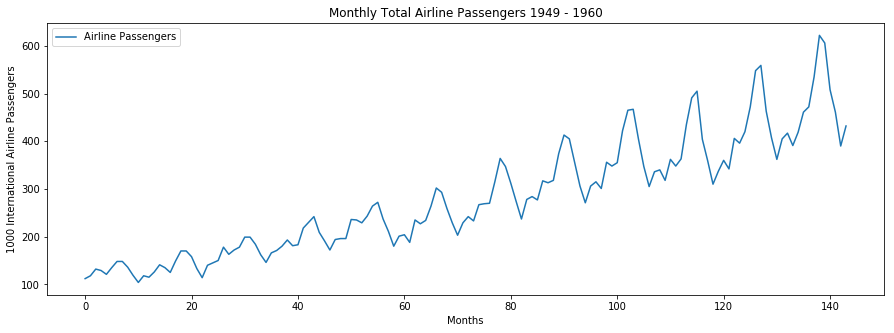

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(df_origin,
              label="Airline Passengers")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Monthly Total Airline Passengers 1949 - 1960")
plt.legend()
plt.show()

# Data preparation

In [10]:
data_raw = df_origin.values.astype("float32")
data_raw[:10]

array([[112.],
       [118.],
       [132.],
       [129.],
       [121.],
       [135.],
       [148.],
       [148.],
       [136.],
       [119.]], dtype=float32)

## Scaling

In [11]:
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)
dataset[:10]

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984557],
       [0.08494207],
       [0.08494207],
       [0.06177607],
       [0.02895753]], dtype=float32)

## データセット整形 1

### Split into test / training data

In [705]:
train_size = 0.6
offset = int(len(dataset) * train_size)
X_train, X_test = dataset[:offset], dataset[offset:]

In [706]:
print("train set / test set: {} / {}".format(len(X_train), len(X_test)))

train set / test set: 86 / 58


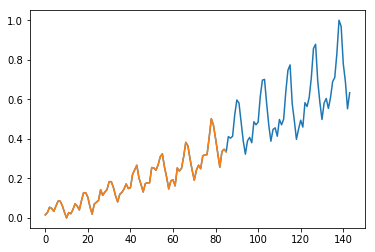

In [707]:
plt.plot(dataset)
plt.plot(X_train)

### 時系列データをKerasで使いやすいように整形

window_size 個のデータを使用し、次のタイムステップの値を予測する

In [716]:
def create_dataset(dataset, window_size=1):
    X, y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:(i + window_size), 0])
        y.append(dataset[i + window_size, 0])
#     X = np.reshape(np.array(X), (np.array(X).shape[0], np.array(X).shape[1], 1))
    X = np.reshape(np.array(X), (np.array(X).shape[0], 1, np.array(X).shape[1]))
    y = np.reshape(np.array(y), ([-1, 1]))
#     X = np.reshape(np.array(X), [-1, window_size, 1])
 #    y = np.reshape(np.array(y), [-1, 1])
    return X, y

In [717]:
window_size = 12
X_train_seq, y_train_seq = create_dataset(X_train, window_size)
X_test_seq, y_test_seq = create_dataset(X_test, window_size)
print(X_train_seq.shape, y_train_seq.shape)

(74, 1, 12) (74, 1)


In [718]:
print(X_train_seq[0:2])
print(y_train_seq[0:2])

[[[0.01544401 0.02702703 0.05405405 0.04826255 0.03281853 0.05984557
   0.08494207 0.08494207 0.06177607 0.02895753 0.         0.02702703]]

 [[0.02702703 0.05405405 0.04826255 0.03281853 0.05984557 0.08494207
   0.08494207 0.06177607 0.02895753 0.         0.02702703 0.02123553]]]
[[0.02123553]
 [0.04247104]]


# Build simple LSTM model

In [726]:
def fit_model(X, y, window_size=1):
    model = Sequential()
    model.add(LSTM(4,
                                   input_shape=(1, window_size)))
    model.add(Dense(1))
    model.compile(loss="mse",
                               optimizer="adam")
    model.fit(X,
                     y,
                     epochs=100,
                     batch_size=1,
                     verbose=1)
    return model

In [721]:
since = time.time()
model1 = fit_model(X_train_seq, y_train_seq, window_size)
display_formatted_time(time.time() - since)

Epoch 1/100
74/74 [==============================] - 5s 62ms/step - loss: 0.0194
Epoch 2/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 3/100
74/74 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 4/100
74/74 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 5/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 6/100
74/74 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 7/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 8/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 9/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 10/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 11/100
74/74 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 12/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 13/100
74/74 [================

74/74 [==============================] - 0s 3ms/step - loss: 6.0758e-04
Epoch 99/100
74/74 [==============================] - 0s 2ms/step - loss: 6.7427e-04
Epoch 100/100
74/74 [==============================] - 0s 3ms/step - loss: 5.9099e-04
Elapsed time - : 0min 24s


## Predict

In [925]:
def predict_and_score(model, X, y):
    pred = scaler.inverse_transform(model.predict(X))
    y_true = scaler.inverse_transform(y)
    score = math.sqrt(mean_squared_error(y_true, pred[:, 0]))
    return score, pred

In [926]:
rmse_train, pred_train = predict_and_score(model1, X_train_seq, y_train_seq)
rmse_test, pred_test = predict_and_score(model1, X_test_seq, y_test_seq)

print("RMSE")
print("Train score: %.2f" % rmse_train)
print("Test score: %.2f" % rmse_test)

RMSE
Train score: 12.70
Test score: 29.44


# Plot

In [929]:
def plot_pred(dataset, pred_train, pred_test):
    train_predict_plot = np.empty_like(dataset)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[window_size:(len(pred_train) + window_size), :] = pred_train

    test_predict_plot = np.empty_like(dataset)
    test_predict_plot[:, :] = np.nan
    test_predict_plot[(len(pred_train) + window_size * 2):((len(pred_train) + window_size * 2) + len(pred_test)), :] = pred_test
    
    plt.figure(figsize=(15, 10))
    plt.plot(df_origin)
    plt.plot(train_predict_plot)
    plt.plot(test_predict_plot)

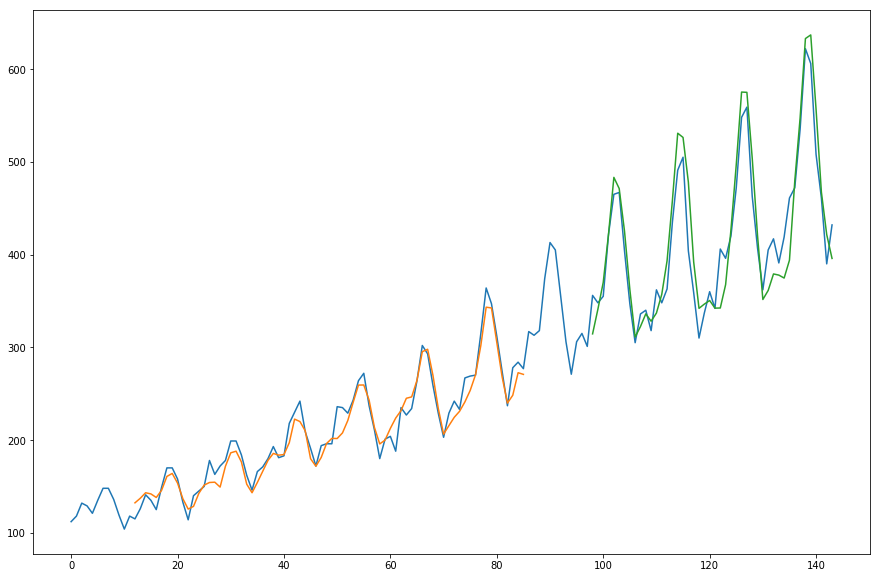

In [930]:
plot_pred(dataset, pred_train, pred_test)

# Build LSTM model

In [931]:
def fit_model2(X, y, window_size=1):
    model = Sequential()
    model.add(LSTM(units=window_size,
                                   input_shape=(1, window_size),
                                   return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(512))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation("linear"))
    model.compile(loss="mse",
                               optimizer="adam")
    model.summary()
    model.fit(X,
                     y,
                     epochs=100,
                     batch_size=32,
                     verbose=1)
    return model

In [932]:
since = time.time()
model2 = fit_model2(X_train_seq, y_train_seq, window_size)
display_formatted_time(time.time() - since)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_81 (LSTM)               (None, 1, 12)             1200      
_________________________________________________________________
dropout_22 (Dropout)         (None, 1, 12)             0         
_________________________________________________________________
lstm_82 (LSTM)               (None, 512)               1075200   
_________________________________________________________________
dropout_23 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 513       
_________________________________________________________________
activation_11 (Activation)   (None, 1)                 0         
Total params: 1,076,913
Trainable params: 1,076,913
Non-trainable params: 0
_________________________________________________________________


74/74 [==============================] - 0s 715us/step - loss: 0.0023
Epoch 87/100
74/74 [==============================] - 0s 748us/step - loss: 0.0023
Epoch 88/100
74/74 [==============================] - 0s 727us/step - loss: 0.0027
Epoch 89/100
74/74 [==============================] - 0s 751us/step - loss: 0.0024
Epoch 90/100
74/74 [==============================] - 0s 745us/step - loss: 0.0029
Epoch 91/100
74/74 [==============================] - 0s 762us/step - loss: 0.0018
Epoch 92/100
74/74 [==============================] - 0s 750us/step - loss: 0.0029
Epoch 93/100
74/74 [==============================] - 0s 770us/step - loss: 0.0023
Epoch 94/100
74/74 [==============================] - 0s 778us/step - loss: 0.0021
Epoch 95/100
74/74 [==============================] - 0s 767us/step - loss: 0.0018
Epoch 96/100
74/74 [==============================] - 0s 764us/step - loss: 0.0022
Epoch 97/100
74/74 [==============================] - 0s 755us/step - loss: 0.0020
Epoch 98/100
74/7

In [933]:
rmse_train, pred_train = predict_and_score(model2, X_train_seq, y_train_seq)
rmse_test, pred_test = predict_and_score(model2, X_test_seq, y_test_seq)

print("Train score: %.2f" % rmse_train)
print("Test score: %.2f" % rmse_test)

Train score: 16.75
Test score: 36.00


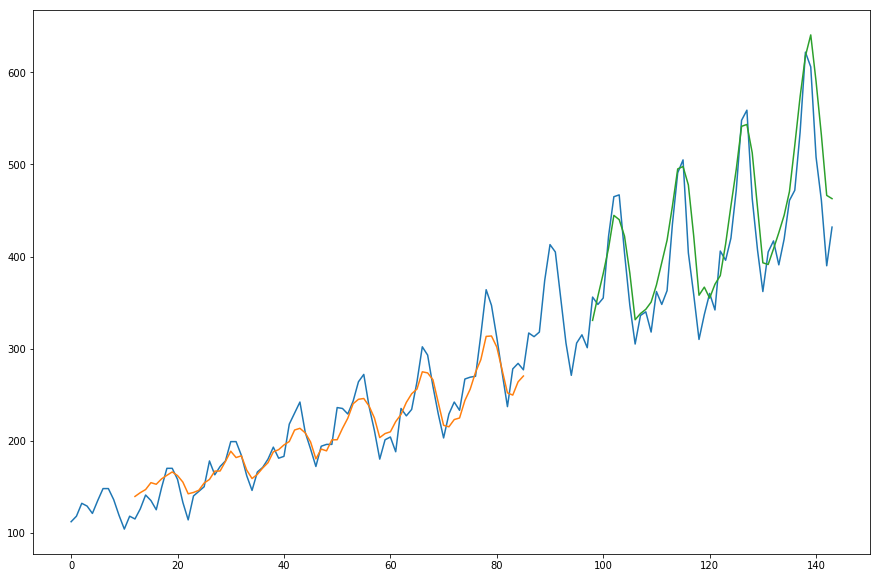

In [934]:
plot_pred(dataset, pred_train, pred_test)

___

# データセット整形 2 (Keras ver)

1. `generate_timeseries()` で `TimeseriesGenerator` を作成
2. `create_generator()` で `TimeseriesGenerator` から `Generator` を作成

In [12]:
length = 3
sampling_rate = 1
stride = 1
batch_size = 1

In [13]:
def generate_timeseries(X, y, phase="train", train_size=0.7, val_size=0):
    if phase == "train":
        return TimeseriesGenerator(X, 
                                                         y,
                                                         length=length,
                                                         sampling_rate=sampling_rate,  # length 個からサンプリングする間隔
                                                         stride=stride,  # 何個置きに length 個の塊を作るか
                                                         end_index=int(len(dataset)*train_size),
                                                         batch_size=batch_size)
    else:
        return TimeseriesGenerator(X, 
                                                         y,
                                                         length=length,
                                                         sampling_rate=sampling_rate,  # length 個からサンプリングする間隔
                                                         stride=stride,  # 何個置きに length 個の塊を作るか
                                                         start_index=int(len(dataset)*train_size),
                                                         batch_size=batch_size)
    """
    if phase == "train":
        data_gen = TimeseriesGenerator(X, 
                                                         y,
                                                         length=length,
                                                         sampling_rate=sampling_rate,  # length 個からサンプリングする間隔
                                                         stride=stride,  # 何個置きに length 個の塊を作るか
                                                         end_index=int(len(dataset)*train_size),
                                                         batch_size=batch_size)
    else:
        data_gen = TimeseriesGenerator(X, 
                                                         y,
                                                         length=length,
                                                         sampling_rate=sampling_rate,  # length 個からサンプリングする間隔
                                                         stride=stride,  # 何個置きに length 個の塊を作るか
                                                         start_index=int(len(dataset)*train_size),
                                                         batch_size=batch_size)
    """

In [14]:
def create_generator(timeseries_generator):    
    while True:
        for i in range(len(timeseries_generator)):
            x, y = timeseries_generator[i]
            yield x, y

In [16]:
model = Sequential()
model.add(LSTM(4,
                               input_shape=(length, 1)))
model.add(Dense(1))
model.compile(loss="mse",
                           optimizer="adam")

In [17]:
train_tsgen = generate_timeseries(dataset, dataset, phase="train", train_size=0.6)
test_tsgen = generate_timeseries(dataset, dataset, phase="test", train_size=0.6)

In [18]:
train_gen = create_generator(train_tsgen)
test_gen = create_generator(test_tsgen)

### Helper

In [19]:
def get_y_true(generator):
    y = None
    for i in range(len(generator)):
        batch_y = generator[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1, 1))
    return y

## Training

`fit_generator()` には `Generator` をわたす

In [20]:
history = model.fit_generator(train_gen,
                                                     epochs=10,
                                                     steps_per_epoch=int(np.ceil(len(train_tsgen) / batch_size))).history  # データ数 / batch size

Epoch 1/10
84/84 [==============================] - 1s 10ms/step - loss: 0.0067
Epoch 2/10
84/84 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 3/10
84/84 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 4/10
84/84 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 5/10
84/84 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 6/10
84/84 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 7/10
84/84 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 8/10
84/84 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 9/10
84/84 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 10/10
84/84 [==============================] - 0s 3ms/step - loss: 0.0035


In [22]:
model.evaluate_generator(test_gen, steps=len(test_tsgen))

0.017104422467062622

## Predicting

In [23]:
y_pred_train = model.predict_generator(train_gen, steps=len(train_tsgen))
y_pred_test = model.predict_generator(test_gen, steps=len(test_tsgen))

In [24]:
print(y_pred_train.shape)
print(y_pred_test.shape)

(84, 1)
(55, 1)


In [25]:
y_pred_train = scaler.inverse_transform(y_pred_train)
y_pred_test = scaler.inverse_transform(y_pred_test)

y 正解取得

In [26]:
y_true_train = get_y_true(train_tsgen)
y_true_test = get_y_true(test_tsgen)

In [27]:
y_true_train = scaler.inverse_transform(y_true_train)
y_true_test = scaler.inverse_transform(y_true_test)

In [28]:
score_train = math.sqrt(mean_squared_error(y_true_train, y_pred_train))
score_test = math.sqrt(mean_squared_error(y_true_test, y_pred_test))
print("Train Score: %.2f RMSE" % (score_train))
print("Test Score: %.2f RMSE" % (score_test))

Train Score: 68.01 RMSE
Test Score: 110.97 RMSE


## Plot

In [33]:
def plot_pred2(dataset, pred_train, pred_test):
    train_predict_plot = np.empty_like(dataset)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[length:(len(pred_train) + length), :] = pred_train

    test_predict_plot = np.empty_like(dataset)
    test_predict_plot[:, :] = np.nan
    test_predict_plot[(len(pred_train) + length * 2 - 1):((len(pred_train) + length * 2) + len(pred_test)), :] = pred_test
    
    plt.figure(figsize=(15, 10))
    plt.plot(df_origin)
    plt.plot(train_predict_plot)
    plt.plot(test_predict_plot)

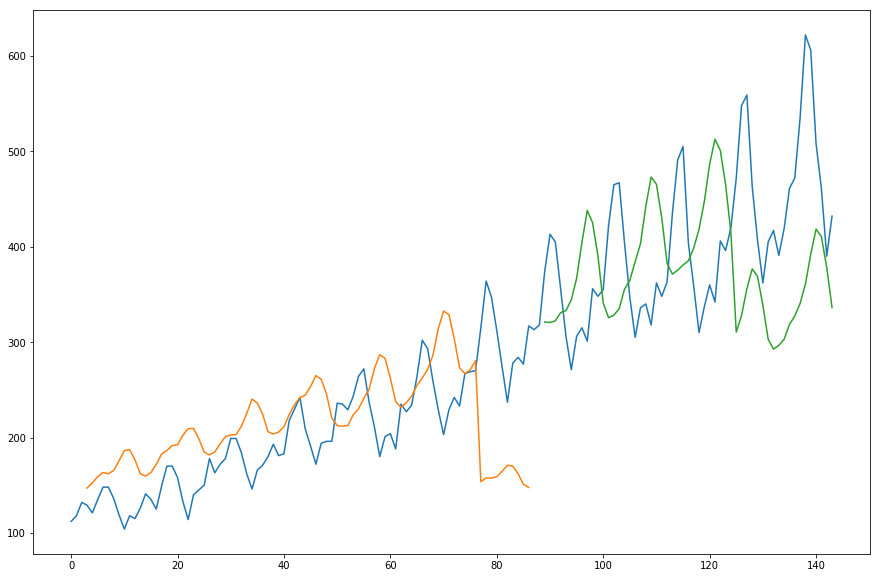

In [34]:
plot_pred2(dataset, y_pred_train, y_pred_test)

___